YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Weights of Optimal Portfolio:
GC=F: 27.50%
BTC-USD: 72.50%
Expected Return: 20.94%
Expected Volatility: 18.23%
Sharpe Ratio: 1.09


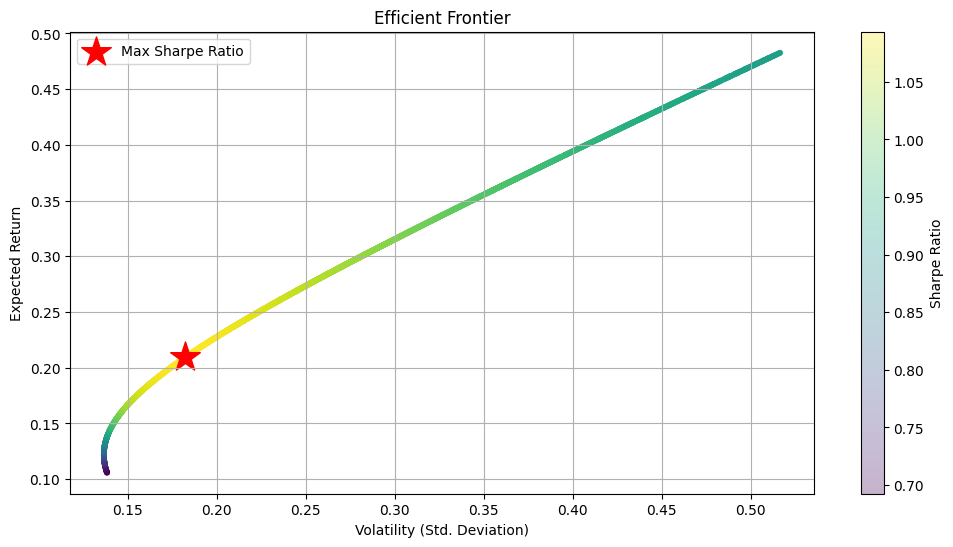

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. ดึงข้อมูลราคาหุ้นย้อนหลัง
# tickers = ['^GSPC', 'GC=F', 'BTC-USD']
tickers = ['GC=F', 'BTC-USD']
data = yf.download(tickers, start='2020-01-01', end='2026-01-01')['Close']

# 2. คำนวณผลตอบแทนรายวัน
returns = data.pct_change().dropna()

# 3. สร้างฟังก์ชันที่จำเป็น
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std

def check_sum(weights):
    return np.sum(weights) - 1

# 4. คำนวณค่าที่ต้องใช้
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
num_assets = len(tickers)

# 5. สร้าง Efficient Frontier
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = p_std
    results[1,i] = p_return
    results[2,i] = (p_return - 0.01) / p_std  # Sharpe Ratio

# 6. หาพอร์ตที่ Sharpe สูงสุด
initial_weights = num_assets * [1. / num_assets]
bounds = tuple((0,1) for _ in range(num_assets))
constraints = {'type': 'eq', 'fun': check_sum}

opt_result = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

opt_weights = opt_result.x
opt_return, opt_std = portfolio_performance(opt_weights, mean_returns, cov_matrix)
opt_sharpe = (opt_return - 0.01) / opt_std

# 7. แสดงผลลัพธ์
print("Weights of Optimal Portfolio:")
for ticker, weight in zip(tickers, opt_weights):
    print(f"{ticker}: {weight:.2%}")
print(f"Expected Return: {opt_return:.2%}")
print(f"Expected Volatility: {opt_std:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")

# 8. วาด Efficient Frontier
plt.figure(figsize=(12, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_std, opt_return, marker='*', color='r', s=500, label='Max Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  2 of 2 completed


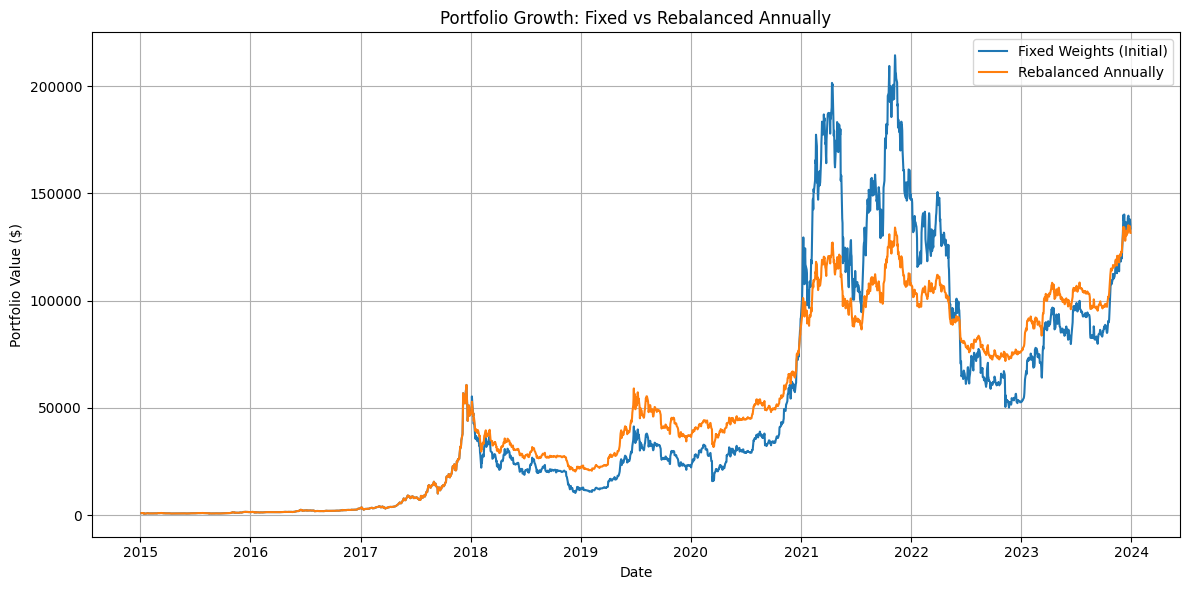

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 1. Load data
# tickers = ['^GSPC', 'GC=F', 'BTC-USD']
tickers = ['GC=F', 'BTC-USD']
data = yf.download(tickers, start='2015-01-01', end='2024-12-31')['Close']
data = data.dropna()

# 2. Daily returns
returns = data.pct_change().dropna()

# 3. Optimization Function
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std

def check_sum(weights):
    return np.sum(weights) - 1

def optimize_weights(ret_window):
    mean_ret = ret_window.mean() * 252
    cov = ret_window.cov() * 252
    init_w = [1./len(tickers)] * len(tickers)
    bounds = tuple((0, 1) for _ in tickers)
    constraints = {'type': 'eq', 'fun': check_sum}
    opt = minimize(negative_sharpe_ratio, init_w, args=(mean_ret, cov), 
                   method='SLSQP', bounds=bounds, constraints=constraints)
    return opt.x

# 4. Rebalancing
initial_weights = optimize_weights(returns[:252])  # Use first year
portfolio_fixed = [1000]  # Start with $1000
portfolio_dynamic = [1000]
weights_dynamic = initial_weights.copy()

dates = []
current_value_fixed = np.array([w * 1000 for w in initial_weights])
current_value_dynamic = current_value_fixed.copy()

for year in range(2015, 2024):
    start = f'{year}-01-01'
    end = f'{year}-12-31'
    yearly_data = returns.loc[start:end]
    if yearly_data.empty:
        continue

    for date, daily_return in yearly_data.iterrows():
        # Update fixed portfolio (same weights)
        current_value_fixed *= (1 + daily_return)
        portfolio_fixed.append(np.sum(current_value_fixed))

        # Update dynamic portfolio (rebalanced yearly)
        current_value_dynamic *= (1 + daily_return)
        portfolio_dynamic.append(np.sum(current_value_dynamic))

        dates.append(date)

    # Rebalance dynamic at year end
    weights_dynamic = optimize_weights(returns.loc[:end])
    current_value_dynamic = np.sum(current_value_dynamic) * weights_dynamic

# 5. Plot
plt.figure(figsize=(12,6))
plt.plot(dates, portfolio_fixed[1:], label='Fixed Weights (Initial)')
plt.plot(dates, portfolio_dynamic[1:], label='Rebalanced Annually')
plt.title('Portfolio Growth: Fixed vs Rebalanced Annually')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  3 of 3 completed



📈 Portfolio Weights by Year (Rebalanced):

Ticker BTC-USD    GC=F    ^GSPC
Year                           
2014     0.00%   0.00%  100.00%
2015    33.89%   0.00%   66.11%
2016    36.53%   0.00%   63.47%
2017    26.16%  15.83%   58.01%
2018    30.13%  13.60%   56.27%
2019    15.40%  28.29%   56.31%
2020    25.76%  37.59%   36.65%
2021    23.73%  29.54%   46.74%
2022    27.81%  38.00%   34.19%
2023    25.18%  37.90%   36.92%
2024    21.48%  43.05%   35.47%
2025    19.40%  48.68%   31.92%

📊 Portfolio Performance Summary:

                Fixed Rebalanced
CAGR           11.27%     42.01%
Volatility     18.01%     28.92%
Sharpe Ratio     0.63       1.33
Max Drawdown  -33.92%    -41.94%


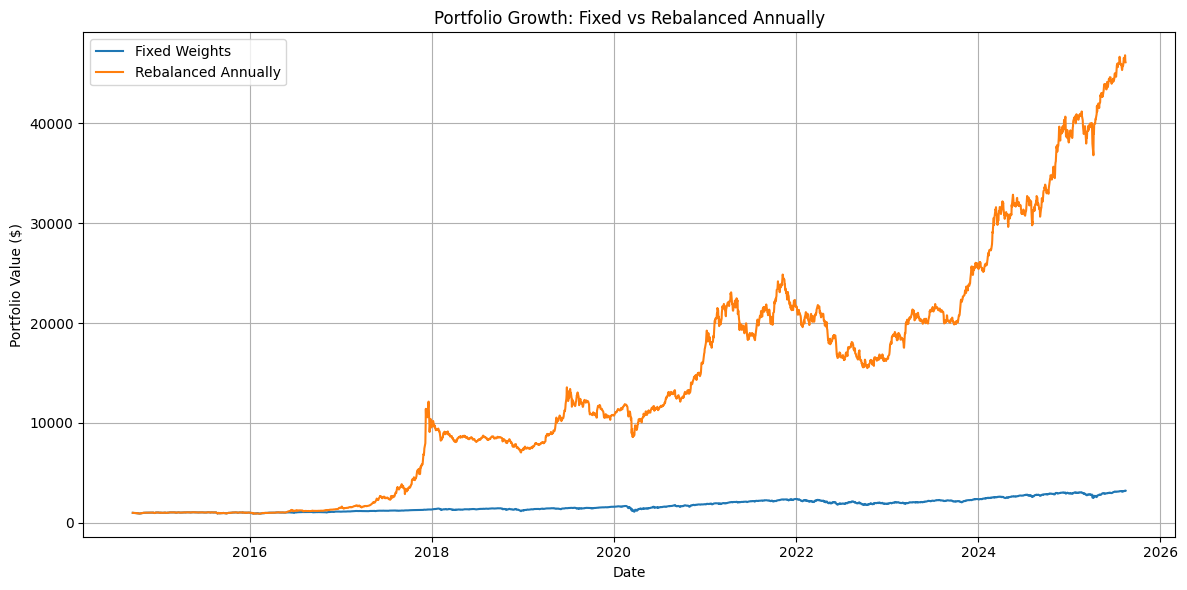

In [32]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ========== STEP 1: Load Data ==========
tickers = ['^GSPC', 'GC=F', 'BTC-USD']
# tickers = ['GC=F', 'BTC-USD']
data = yf.download(tickers, start='2014-01-01', end='2026-12-31')['Close']
data = data.dropna()
returns = data.pct_change().dropna()

# ========== STEP 2: Helper Functions ==========
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, std

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_ret, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

def check_sum(weights):
    return np.sum(weights) - 1

def optimize_weights(ret_window):
    mean_ret = ret_window.mean() * 252
    cov = ret_window.cov() * 252
    init_w = [1./len(tickers)] * len(tickers)
    bounds = tuple((0, 1) for _ in tickers)
    constraints = {'type': 'eq', 'fun': check_sum}
    opt = minimize(negative_sharpe_ratio, init_w, args=(mean_ret, cov),
                   method='SLSQP', bounds=bounds, constraints=constraints)
    return opt.x

def calculate_cagr(portfolio_values, dates):
    years = (dates[-1] - dates[0]).days / 365.25
    return (portfolio_values[-1] / portfolio_values[0]) ** (1 / years) - 1

def calculate_volatility(portfolio_returns):
    return np.std(portfolio_returns) * np.sqrt(252)

def calculate_sharpe(portfolio_returns, risk_free_rate=0.01):
    excess_ret = portfolio_returns - (risk_free_rate / 252)
    return np.mean(excess_ret) / np.std(portfolio_returns) * np.sqrt(252)

def calculate_max_drawdown(portfolio_values):
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - peak) / peak
    return drawdown.min()

# ========== STEP 3: Simulation Loop ==========
initial_weights = optimize_weights(returns[:252])
portfolio_fixed = [1000]
portfolio_dynamic = [1000]
weights_dynamic = initial_weights.copy()

dates = []
current_value_fixed = np.array([w * 1000 for w in initial_weights])
current_value_dynamic = current_value_fixed.copy()

returns_fixed_daily = []
returns_dynamic_daily = []

for year in range(2014, 2026):
    start = f'{year}-01-01'
    end = f'{year}-12-31'
    yearly_data = returns.loc[start:end]
    if yearly_data.empty:
        continue

    for date, daily_return in yearly_data.iterrows():
        prev_total_fixed = np.sum(current_value_fixed)
        prev_total_dynamic = np.sum(current_value_dynamic)

        current_value_fixed *= (1 + daily_return)
        current_value_dynamic *= (1 + daily_return)

        portfolio_fixed.append(np.sum(current_value_fixed))
        portfolio_dynamic.append(np.sum(current_value_dynamic))

        returns_fixed_daily.append(np.sum(current_value_fixed) / prev_total_fixed - 1)
        returns_dynamic_daily.append(np.sum(current_value_dynamic) / prev_total_dynamic - 1)

        dates.append(date)
        weights_dynamic = initial_weights.copy()

    # Rebalance dynamic
    weights_dynamic = optimize_weights(returns.loc[:end])
    # บันทึก weights ของพอร์ตแบบ dynamic
    if 'weights_by_year' not in locals():
        weights_by_year = {}

    weights_by_year[year] = weights_dynamic
    current_value_dynamic = np.sum(current_value_dynamic) * weights_dynamic

# ========== STEP 4: Convert to Array ==========
portfolio_fixed = np.array(portfolio_fixed[1:])
portfolio_dynamic = np.array(portfolio_dynamic[1:])
returns_fixed_daily = np.array(returns_fixed_daily)
returns_dynamic_daily = np.array(returns_dynamic_daily)
dates = pd.to_datetime(dates)

# ========== STEP 5: Summary Stats ==========
stats = pd.DataFrame(index=['CAGR', 'Volatility', 'Sharpe Ratio', 'Max Drawdown'])

stats['Fixed'] = [
    calculate_cagr(portfolio_fixed, dates),
    calculate_volatility(returns_fixed_daily),
    calculate_sharpe(returns_fixed_daily),
    calculate_max_drawdown(portfolio_fixed)
]

stats['Rebalanced'] = [
    calculate_cagr(portfolio_dynamic, dates),
    calculate_volatility(returns_dynamic_daily),
    calculate_sharpe(returns_dynamic_daily),
    calculate_max_drawdown(portfolio_dynamic)
]
# สร้าง DataFrame ของ weights แต่ละปี
weight_df = pd.DataFrame(weights_by_year, index=data.columns).T
weight_df.index.name = 'Year'
weight_df.index = weight_df.index.astype(int)
weight_df = weight_df.sort_index()

print("\n📈 Portfolio Weights by Year (Rebalanced):\n")
print(weight_df.applymap(lambda x: f"{x:.2%}"))

print("\n📊 Portfolio Performance Summary:\n")
def format_metric(value, row):
    if row in ['CAGR', 'Volatility', 'Max Drawdown']:
        return f"{value:.2%}"
    else:
        return f"{value:.2f}"  # Sharpe Ratio

# Apply format per row
formatted_stats = stats.copy()
for row in stats.index:
    formatted_stats.loc[row] = stats.loc[row].apply(lambda x: format_metric(x, row))
print(formatted_stats)

# ========== STEP 6: Plot ==========
plt.figure(figsize=(12,6))
plt.plot(dates, portfolio_fixed, label='Fixed Weights')
plt.plot(dates, portfolio_dynamic, label='Rebalanced Annually')
plt.title('Portfolio Growth: Fixed vs Rebalanced Annually')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  3 of 3 completed



📈 Portfolio Weights by Year (Rebalanced):

      BTC-USD    GC=F   ^GSPC    USD
Year                                
2015  100.00%   0.00%   0.00%  0.00%
2016   51.86%   0.00%  48.14%  0.00%
2017   27.46%  20.22%  52.32%  0.00%
2018   31.71%  21.81%  46.48%  0.00%
2019   15.98%  31.79%  52.22%  0.00%
2020   27.01%  40.86%  32.13%  0.00%
2021   24.85%  32.49%  42.67%  0.00%
2022   29.38%  41.74%  28.88%  0.00%
2023   26.51%  40.83%  32.66%  0.00%
2024   22.49%  45.38%  32.13%  0.00%
2025   20.30%  50.63%  29.07%  0.00%

📊 Portfolio Performance Summary:

                Fixed Rebalanced
CAGR           77.01%     60.03%
Volatility     67.59%     39.83%
Sharpe Ratio     1.15       1.32
Max Drawdown  -83.04%    -42.94%


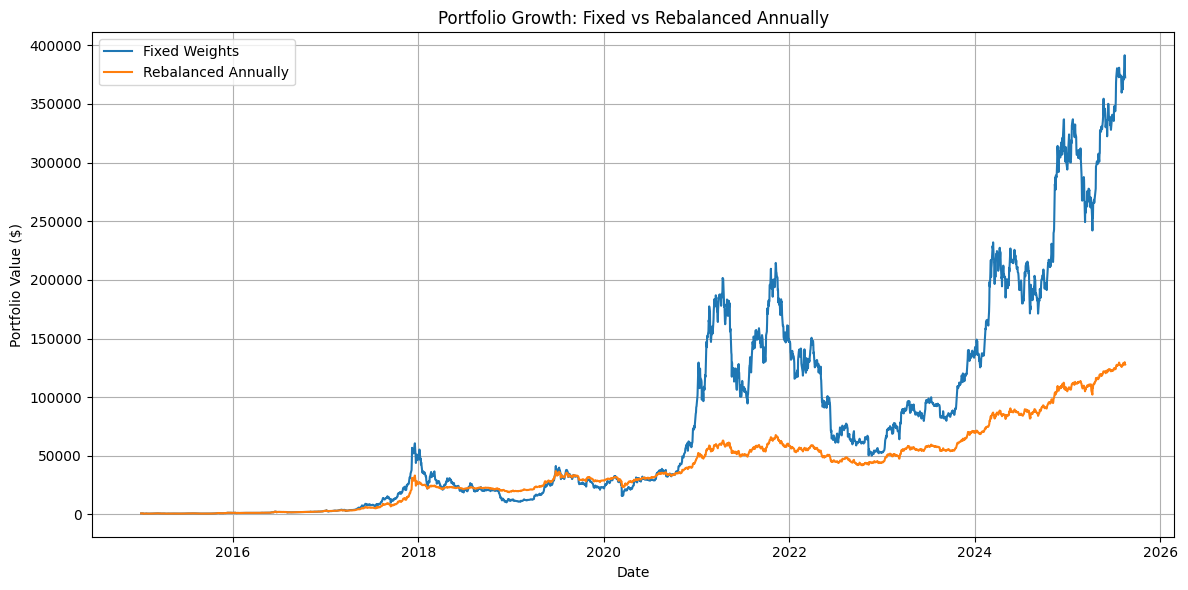

In [52]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ========== STEP 1: Load Data ==========
tickers = ['^GSPC', 'GC=F', 'BTC-USD']

data = yf.download(tickers, start='2015-01-01', end='2026-12-31')['Close']
data = data.dropna()
returns = data.pct_change().dropna()

# เพิ่ม USD เป็นสินทรัพย์ปลอดภัย (ผลตอบแทนคงที่)
usd_daily_return = 0.005 / 252  # ≈ 0.5% ต่อปี
returns['USD'] = usd_daily_return

# ใช้ชื่อสินทรัพย์จาก returns เสมอ (จะรวม USD ด้วย)
asset_names = list(returns.columns)   # e.g. ['^GSPC', 'GC=F', 'BTC-USD', 'USD']
n_assets = len(asset_names)

# ========== STEP 2: Helper Functions ==========
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, std

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_ret, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    # ป้องกันหารศูนย์
    if p_std == 0:
        return 1e9
    return -(p_ret - risk_free_rate) / p_std

def check_sum(weights):
    return np.sum(weights) - 1

def optimize_weightss(ret_window):
    """รับ DataFrame ของผลตอบแทนรายวัน -> คืนเวกเตอร์น้ำหนักต่อสินทรัพย์ (len = ret_window.columns)"""
    mean_ret = ret_window.mean() * 252
    cov = ret_window.cov() * 252
    init_w = np.array([1.0/len(ret_window.columns)] * len(ret_window.columns))
    bounds = tuple((0, 1) for _ in ret_window.columns)
    constraints = {'type': 'eq', 'fun': check_sum}
    opt = minimize(negative_sharpe_ratio, init_w, args=(mean_ret.values, cov.values),
                   method='SLSQP', bounds=bounds, constraints=constraints)
    # กันพลาด (เช่น ล้มเหลว) -> คืนค่าเฉลี่ยเท่ากัน
    if (not opt.success) or (np.any(np.isnan(opt.x))):
        return init_w
    # ทำให้รวมเป็น 1 เผื่อเลขลอยตัวเพี้ยน
    w = np.clip(opt.x, 0, 1)
    s = w.sum()
    return w / s if s > 0 else init_w

def optimize_weights(ret_window):
    mean_ret = ret_window.mean() * 252
    cov = ret_window.cov() * 252
    n = len(ret_window.columns)

    init_w = np.array([1.0/n] * n)
    bounds = []
    for col in ret_window.columns:
        if col == "USD":
            bounds.append((0.0, 1))   # USD อย่างน้อย 1%
        else:
            bounds.append((0, 1))

    constraints = {'type': 'eq', 'fun': check_sum}

    opt = minimize(negative_sharpe_ratio, init_w, args=(mean_ret.values, cov.values),
                   method='SLSQP', bounds=tuple(bounds), constraints=constraints)

    if (not opt.success) or (np.any(np.isnan(opt.x))):
        return init_w

    w = np.clip(opt.x, 0, 1)
    return w / w.sum()


def calculate_cagr(portfolio_values, dates):
    years = (dates[-1] - dates[0]).days / 365.25
    return (portfolio_values[-1] / portfolio_values[0]) ** (1 / years) - 1

def calculate_volatility(portfolio_returns):
    return np.std(portfolio_returns) * np.sqrt(252)

def calculate_sharpe(portfolio_returns, risk_free_rate=0.01):
    excess_ret = portfolio_returns - (risk_free_rate / 252)
    denom = np.std(portfolio_returns)
    if denom == 0:
        return np.nan
    return np.mean(excess_ret) / denom * np.sqrt(252)

def calculate_max_drawdown(portfolio_values):
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - peak) / peak
    return drawdown.min()

# ========== STEP 3: Simulation Loop ==========
# initial weights จากช่วงแรก ~ 1 ปีทำการ
first_window = returns.iloc[:252]
# ตรวจว่ามีคอลัมน์ USD อยู่จริง
assert set(asset_names).issubset(set(first_window.columns)) or 'USD' in returns.columns

initial_weights = optimize_weights(first_window)

# เตรียมพอร์ต (ถือมูลค่าตามสินทรัพย์)
portfolio_fixed = [1000.0]
portfolio_dynamic = [1000.0]

current_value_fixed = np.array([w * 1000.0 for w in initial_weights], dtype=float)
current_value_dynamic = current_value_fixed.copy()

returns_fixed_daily = []
returns_dynamic_daily = []
dates = []

# เก็บน้ำหนักต่อปี (หลัง rebalance ตอนสิ้นปี)
weights_by_year = {}

for year in range(2015, 2026):
    start = f'{year}-01-01'
    end = f'{year}-12-31'
    yearly_data = returns.loc[start:end]

    # ข้ามถ้าไม่มีข้อมูลปีนี้
    if yearly_data.empty:
        continue

    # ให้แน่ใจว่าคอลัมน์เรียงตาม asset_names
    yearly_data = yearly_data.reindex(columns=asset_names)

    for date, daily_return in yearly_data.iterrows():
        prev_total_fixed = np.sum(current_value_fixed)
        prev_total_dynamic = np.sum(current_value_dynamic)

        # เติบโตตามผลตอบแทนของแต่ละสินทรัพย์ (คงน้ำหนักเดิมภายในปี)
        growth = (1.0 + daily_return.values)
        current_value_fixed *= growth
        current_value_dynamic *= growth

        # บันทึกมูลค่าพอร์ตและผลตอบแทนวัน
        new_total_fixed = np.sum(current_value_fixed)
        new_total_dynamic = np.sum(current_value_dynamic)

        portfolio_fixed.append(new_total_fixed)
        portfolio_dynamic.append(new_total_dynamic)

        returns_fixed_daily.append(new_total_fixed / prev_total_fixed - 1.0)
        returns_dynamic_daily.append(new_total_dynamic / prev_total_dynamic - 1.0)

        dates.append(date)

    # ===== Rebalance dynamic ที่สิ้นปี =====
    # ใช้ข้อมูลตั้งแต่เริ่มต้นถึงสิ้นปีนี้ (ตามไอเดียเดิมของคุณ)
    hist_to_year_end = returns.loc[:end].reindex(columns=asset_names)
    w_dyn = optimize_weights(hist_to_year_end)

    # บันทึกน้ำหนักต่อปี (ผูกชื่อคอลัมน์ให้ครบ แล้วเก็บเป็น array ยาว n_assets)
    w_named = pd.Series(w_dyn, index=asset_names[:len(w_dyn)]).reindex(asset_names, fill_value=0.0).values
    weights_by_year[year] = w_named

    # ทำการ rebalance: นำมูลค่ารวม ณ สิ้นปี กระจายตามน้ำหนักใหม่
    total_dyn = np.sum(current_value_dynamic)
    current_value_dynamic = total_dyn * w_named

# ========== STEP 4: Convert to Array for Metrics ==========
portfolio_fixed = np.array(portfolio_fixed[1:])
portfolio_dynamic = np.array(portfolio_dynamic[1:])
returns_fixed_daily = np.array(returns_fixed_daily)
returns_dynamic_daily = np.array(returns_dynamic_daily)
dates = pd.to_datetime(dates)

# ========== STEP 5: Summary Stats ==========
stats = pd.DataFrame(index=['CAGR', 'Volatility', 'Sharpe Ratio', 'Max Drawdown'])

stats['Fixed'] = [
    calculate_cagr(portfolio_fixed, dates),
    calculate_volatility(returns_fixed_daily),
    calculate_sharpe(returns_fixed_daily),
    calculate_max_drawdown(portfolio_fixed)
]

stats['Rebalanced'] = [
    calculate_cagr(portfolio_dynamic, dates),
    calculate_volatility(returns_dynamic_daily),
    calculate_sharpe(returns_dynamic_daily),
    calculate_max_drawdown(portfolio_dynamic)
]

# แปลง weights ต่อปีให้เป็น DataFrame (คอลัมน์ตรงกับ asset_names เสมอ)
weight_df = pd.DataFrame.from_dict(weights_by_year, orient='index', columns=asset_names)
weight_df.index.name = 'Year'
weight_df = weight_df.sort_index()

print("\n📈 Portfolio Weights by Year (Rebalanced):\n")
print(weight_df.applymap(lambda x: f"{x:.2%}"))

print("\n📊 Portfolio Performance Summary:\n")
def format_metric(value, row):
    if row in ['CAGR', 'Volatility', 'Max Drawdown']:
        return f"{value:.2%}"
    else:
        return f"{value:.2f}"  # Sharpe Ratio

formatted_stats = stats.copy()
for row in stats.index:
    formatted_stats.loc[row] = stats.loc[row].apply(lambda x: format_metric(x, row))
print(formatted_stats)

# ========== STEP 6: Plot ==========
plt.figure(figsize=(12,6))
plt.plot(dates, portfolio_fixed, label='Fixed Weights')
plt.plot(dates, portfolio_dynamic, label='Rebalanced Annually')
plt.title('Portfolio Growth: Fixed vs Rebalanced Annually')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


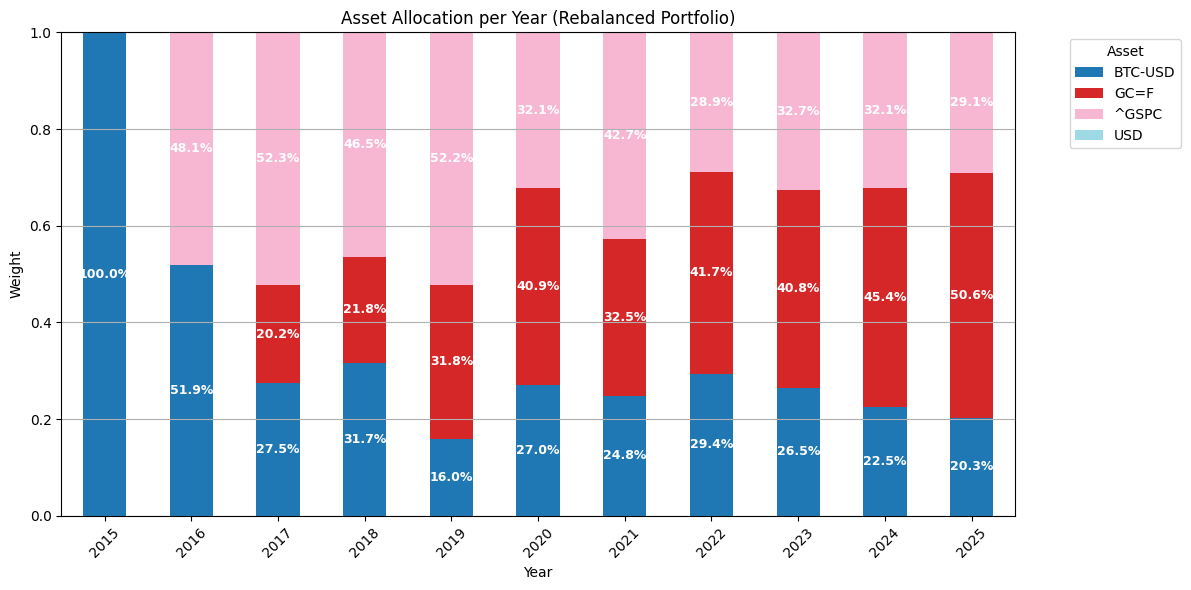

In [50]:
import matplotlib.pyplot as plt

ax = weight_df.plot(kind='bar', stacked=True,figsize=(12,6), colormap='tab20')

plt.title('Asset Allocation per Year (Rebalanced Portfolio)')
plt.ylabel('Weight')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.legend(title='Asset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')

# เพิ่มตัวเลขบนแต่ละ Bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    if height > 0.03:  # แสดงตัวเลขเฉพาะที่น้ำหนักเกิน 3% เพื่อไม่ให้รกเกินไป
        x = p.get_x() + width / 2
        y = p.get_y() + height / 2
        ax.text(x, y, f"{height:.1%}", ha='center', va='center', fontsize=9, color='white', weight='bold')

plt.tight_layout()
plt.show()


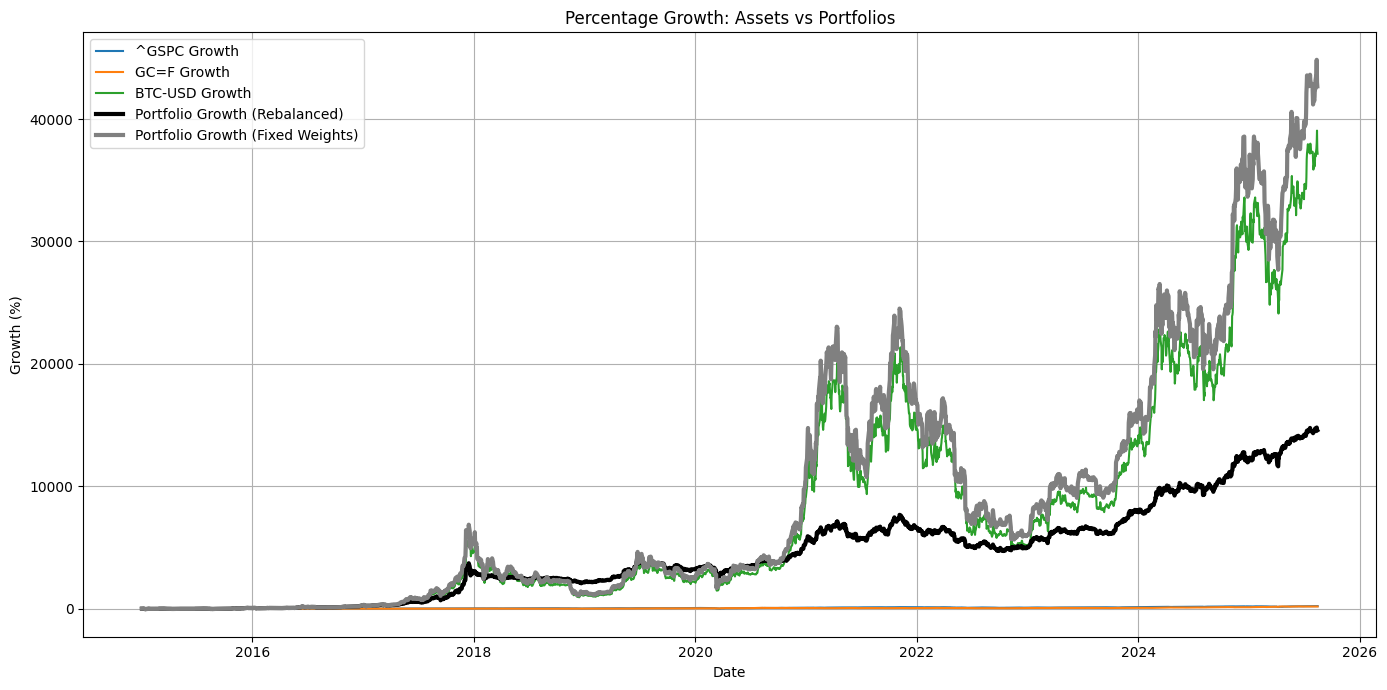

In [51]:
import matplotlib.pyplot as plt

# คำนวณ % Growth ของแต่ละ Asset
pct_growth = (data / data.iloc[0] - 1) * 100  # เปอร์เซ็นต์เติบโตจากวันแรก

plt.figure(figsize=(14,7))

# Plot % Growth ของแต่ละ Asset
for ticker in tickers:
    plt.plot(pct_growth.index, pct_growth[ticker], label=f'{ticker} Growth')

portfolio_dynamic_series = pd.Series(portfolio_dynamic, index=data.index[:len(portfolio_dynamic)])
portfolio_fixed_series = pd.Series(portfolio_fixed, index=data.index[:len(portfolio_fixed)])


# Plot Portfolio Growth (Rebalanced)
plt.plot(portfolio_dynamic_series.index, 
         (portfolio_dynamic_series / portfolio_dynamic_series.iloc[0] - 1) * 100,
         label='Portfolio Growth (Rebalanced)', linewidth=3, color='black')

# Plot Portfolio Growth (Fixed weights)
plt.plot(portfolio_fixed_series.index, 
         (portfolio_fixed_series / portfolio_fixed_series.iloc[0] - 1) * 100,
         label='Portfolio Growth (Fixed Weights)', linewidth=3, color='gray') #, linestyle='--')


plt.title('Percentage Growth: Assets vs Portfolios')
plt.xlabel('Date')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
plt.show()

